# Dummy Modeling 

This notebook attempts to constrain the parameters a, b, c, d in a fake model with dependencies established by a model function mu. The primary goal is to represent higher order variances, as introduced by the flexion, quarxion, etc. from the DALI formalism. 

# 1 Import Statements

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches as patch

# 2 Constants

In [2]:
###############################################################################
n_param = 4

In [3]:
plt.rcParams['figure.facecolor'] = '#212121'
plt.rcParams['axes.facecolor'] = '#212121'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['text.color'] = 'white'
plt.rcParams['savefig.facecolor'] = '#212121'

# 3 Functions

## 3a Model Function and its PDEs

In [4]:
def mu(z, a, b, c, d):
    return a**3*b**2*z**2 + b*c**4*d**3*z + a*c*d*z/b**3 + np.exp(a*z) + a*c*np.sin(d)
#lower dependencies, e.g. just sin(d)

In [5]:
def mu_a(z, a, b, c, d):
    return 3*a**2*b**2*z**2 + c*d*z/b**3 + 2*np.exp(a*z) + c*np.sin(d)

def mu_b(z, a, b, c, d):
    return 2*a**3*b**2*z**2 + c**4*d**3*z - 3*a*c*d*z/b**4

def mu_c(z, a, b, c, d):
    return 4*b*c**3*d**3*z + a*d*z/b**3 + a*np.sin(d)

def mu_d(z, a, b, c, d):
    return 3*b*c**4*d**2*z + a*c*z/b**3 + a*c*np.cos(d)

In [6]:
def mu_aa(z, a, b, c, d):
    return 6*a*b**2*z**2 + z**2*np.exp(a*z)

def mu_ab(z, a, b, c, d):
    return 6*a**2*b*z**2 - 3*c*d*z/b**4

def mu_ac(z, a, b, c, d):
    return d*z/b**3 + np.sin(d)

def mu_ad(z, a, b, c, d):
    return c*z/b**3 + c*np.cos(d)

def mu_bb(z, a, b, c, d):
    return 4*a**3*b*z**2 + 12*a*c*d*z/b**5

def mu_bc(z, a, b, c, d):
    return 4*c**3*d**3*z - 3*a*d*z/b**4

def mu_bd(z, a, b, c, d):
    return 3*c**4*d**2*z - 3*a*c*z/b**4

def mu_cc(z, a, b, c, d):
    return 12*b*c**2*d**3*z

def mu_cd(z, a, b, c, d):
    return 12*b*c**3*d**2*z + a*z/b**3 + a*np.cos(d)

def mu_dd(z, a, b, c, d):
    return 6*b*c**4*d*z - a*c*np.sin(d)

In [7]:
def mu_aaa(z, a, b, c, d):
    return 6*b**2*z**2 + z**3*np.exp(a*z)

def mu_aab(z, a, b, c, d):
    return 12*a*b*z**2

def mu_aac(z, a, b, c, d):
    return 0

def mu_aad(z, a, b, c, d):
    return 0

def mu_abb(z, a, b, c, d):
    return 6*a**2*b*z**2 - 12*c*d/b**5*z

def mu_abc(z, a, b, c, d):
    return -3*d/b**4*z

def mu_abd(z, a, b, c, d):
    return -3*c/b**4*z

def mu_acc(z, a, b, c, d):
    return 0

def mu_acd(z, a, b, c, d):
    return 1/b**3*z + np.cos(d)

def mu_add(z, a, b, c, d):
    return -c*np.sin(d)

def mu_bbb(z, a, b, c, d):
    return 4*a**3*z**2 - 60*a*c*d/b**6*z

def mu_bbc(z, a, b, c, d):
    return 12*a*d/b**5*z

def mu_bbd(z, a, b, c, d):
    return 12*a*c/b**5*z

def mu_bcc(z, a, b, c, d):
    return 12*c**2*d**3*z

def mu_bcd(z, a, b, c, d):
    return 12*c**3*d**2*z - 3*a/b**4*z

def mu_bdd(z, a, b, c, d):
    return 6*c**4*d*z

def mu_ccc(z, a, b, c, d):
    return 24*b*c*d**3*z

def mu_ccd(z, a, b, c, d):
    return 36*b*c**2*d**2*z

def mu_cdd(z, a, b, c, d):
    return 24*b*c**3*d*z - a*np.sin(d)

def mu_ddd(z, a, b, c, d):
    return 6*b*c**4*z - a*c*np.cos(d)

In [8]:
def mu_operator(z, a, b, c, d, i=-1, j=-1, k=-1):
    '''
        where 0,1,2,3 correspond to a,b,c,d respectively
    '''
    mu_dir = [mu,
              [mu_a, mu_b, mu_c, mu_d],
              [[mu_aa, mu_ab, mu_ac, mu_ad],
               [mu_ab, mu_bb, mu_bc, mu_bd],
               [mu_ac, mu_bc, mu_cc, mu_cd],
               [mu_ad, mu_bd, mu_cd, mu_dd]],
              [[[mu_aaa, mu_aab, mu_aac, mu_aad],
                [mu_aab, mu_abb, mu_abc, mu_abd],
                [mu_aac, mu_abc, mu_acc, mu_acd],
                [mu_aad, mu_abd, mu_acd, mu_add]],
               [[mu_aab, mu_abb, mu_abc, mu_abd],
                [mu_abb, mu_bbb, mu_bbc, mu_bbd],
                [mu_abc, mu_bbc, mu_bcc, mu_bcd],
                [mu_abd, mu_bbd, mu_bcd, mu_bdd]],
               [[mu_aac, mu_abc, mu_acc, mu_acd],
                [mu_abc, mu_bbc, mu_bcc, mu_bcd],
                [mu_acc, mu_bcc, mu_ccc, mu_ccd],
                [mu_acd, mu_bcd, mu_ccd, mu_cdd]],
               [[mu_aad, mu_abd, mu_acd, mu_add],
                [mu_abd, mu_bbd, mu_bcd, mu_bdd],
                [mu_acd, mu_bcd, mu_ccd, mu_cdd],
                [mu_add, mu_bdd, mu_cdd, mu_ddd]]]]
    if i >= 0:
        if j >= 0:
            if k >= 0:
                return mu_dir[3][i][j][k](z, a, b, c, d)
            else:
                return mu_dir[2][i][j](z, a, b, c, d)
        else:
            return mu_dir[1][i](z, a, b, c, d)
    else:
        return mu_dir[0](z, a, b, c, d)

## 3b Multivariate Gaussians

In [9]:
def g(a, b, a0, b0, F, F_inv):
    norm = 1/(2*np.pi*np.sqrt(np.linalg.det(F)))
    alpha = a - a0
    beta = b - b0
    curve = np.exp(-1/2 * (F_inv[0,0] * np.matmul(alpha.reshape(-1,1), alpha.reshape(1,-1))
                           + (F_inv[0,1] + F_inv[1,0]) * np.matmul(alpha.reshape(-1,1), beta.reshape(1,-1))
                           + F_inv[1,1] * np.matmul(beta.reshape(-1,1), beta.reshape(1,-1))))
    return norm * curve

In [10]:
def g(a, b, a0, b0, F, F_inv):
    norm = 1/(2*np.pi*np.sqrt(np.linalg.det(F)))
    curve = np.zeros((len(a), len(b)))
    for i, alpha in enumerate(a - a0):
        for j, beta in enumerate(b - b0):
            curve[j,i] = np.exp(-1/2 * (F_inv[0,0]*(alpha)**2 
                                        + (F_inv[0,1] + F_inv[1,0])*(alpha)*(beta) 
                                        + F_inv[1,1]*(beta)**2))
    return norm * curve

In [11]:
def g_a(a, b, a0, b0, F, F_inv, S, S_inv):
    g_F = g(a, b, a0, b0, F, F_inv)
    left = 1/np.linalg.det(S)
    right = 1/2 * (2*S_inv[0,0]*(a-a0) + (S_inv[1,0] + S_inv[0,1])*(b-b0))
    return g_F * (left - right)

In [12]:
def g_b(a, b, a0, b0, S, S_inv):
    g_F = g(a, b, a0, b0, S)
    left = 1/np.linalg.det(S)
    right = 1/2 * (2*S_inv[0,0]*(b-b0) + (S_inv[1,0] + S_inv[0,1])*(a-a0))
    return g_F * (left - right)

In [13]:
def confidence(C, ax, mean=[0,0]):
    x_var = np.sqrt((C[0,0] + C[1,1])/2 + np.sqrt((C[0,0] - C[1,1])**2/4 + (C[0,1])**2))
    y_var = np.sqrt((C[0,0] + C[1,1])/2 - np.sqrt((C[0,0] - C[1,1])**2/4 + (C[0,1])**2))
    alpha = [1.52, 2.48, 3.44]
    theta = (np.arctan((2*C[0,1])/(C[0,0] - C[1,1])))/2 * 180/np.pi
    colors = ['white', 'pink', 'gray']
    labels = ['$1\sigma$', '$2\sigma$', '$3\sigma$']
    for i in range(len(alpha)):
        ax.add_patch(patch.Ellipse(mean, alpha[i]*x_var, alpha[i]*y_var, 
                                   angle=theta, facecolor='none', 
                                   edgecolor=colors[i], label=labels[i], 
                                   linewidth=1.5))
    return x_var, y_var, alpha, theta

def plot_confidence(C, a0, b0, l, r, figsize=6,
                    figname='avb.png'):
    fig, ax = plt.subplots(figsize=(figsize, figsize))
    x_var, y_var, alpha, theta = confidence(C, ax, mean=(a0,b0))
    ax.set_xlim((l[0],r[0]))
    ax.set_ylim((l[1],r[1]))
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.legend()
    plt.title('a vs b Probability Space', size=16)

## 3c DALI Objects

Including the Fisher matrix, its derivative-analogue the Flexion, and its 2nd-derivative the Quarxion.

In [14]:
def F(z, p0, M, n=n_param):
    FISH = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            FISH[i,j] = np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i)).T, M), 
                                  mu_operator(z, p0[0], p0[1], p0[2], p0[3], j))
    return FISH

In [15]:
def S(z, p0, M, n=n_param):
    FLEX = np.zeros((n,n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                FLEX[i,j,k] = np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, j)).T, M), 
                                        mu_operator(z, p0[0], p0[1], p0[2], p0[3], k))
                FLEX[i,j,k] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, k)).T, M), 
                                         mu_operator(z, p0[0], p0[1], p0[2], p0[3], j))
                FLEX[i,j,k] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], j, k)).T, M), 
                                         mu_operator(z, p0[0], p0[1], p0[2], p0[3], i))
    return FLEX

In [16]:
def Q(z, p0, M, n=n_param):
    QUAR = np.zeros((n,n,n,n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    QUAR[i,j,k,l] = np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, j, k)).T, M), 
                                              mu_operator(z, p0[0], p0[1], p0[2], p0[3], l))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, j, l)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], k))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, k, l)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], j))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], j, k, l)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], i))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, j)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], k, l))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, k)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], j, l))
                    QUAR[i,j,k,l] += np.matmul(np.matmul((mu_operator(z, p0[0], p0[1], p0[2], p0[3], i, l)).T, M), 
                                               mu_operator(z, p0[0], p0[1], p0[2], p0[3], j, k))
    return QUAR

## 3d Extra Functions

In [17]:
def dice(A, i, j, k=-1, l=-1):
    if k >= 0:
        if l >= 0:
            return np.array([[A[i,i,k,l], A[i,j,k,l]], [A[j,i,k,l], A[j,j,k,l]]])
        else:
            return np.array([[A[i,i,k], A[i,j,k]], [A[j,i,k], A[j,j,k]]])
    else:
        return np.array([[A[i,i], A[i,j]], [A[j,i], A[j,j]]])

# 4 Temp Workspace

In [18]:
res = 10**3
n_param = 4

l = np.array([-2,0,-2,0])
r = np.array([6,8,6,8])

a = np.linspace(l[0],r[0],res)
b = np.linspace(l[1],r[1],res)
c = np.linspace(l[2],r[2],res)
d = np.linspace(l[3],r[3],res)

a0 = 2
b0 = 4
c0 = 3
d0 = 3

In [19]:
p = np.array([a,b,c,d])
p0 = np.array([a0,b0,c0,d0])

In [20]:
n_var = 5*10**1
C = np.random.randint(10**4,size=(n_var,n_var))/(2*10**6)
for i in range(n_var): 
    while C[i,i] < 10**-2: C[i,i] *= 5*10**0
C = (C+C.T)/2
M = np.linalg.inv(C)

z = np.linspace(5*10**-1,10**0,n_var)

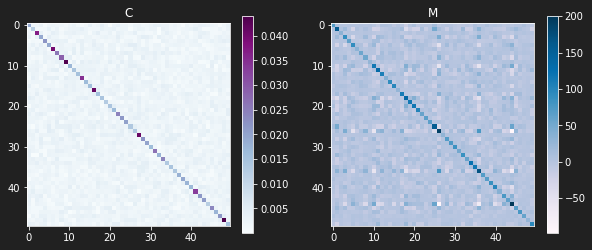

In [21]:
fig, ax = plt.subplots(1, 2)
im = ax[0].imshow(C, cmap='BuPu')
fig.colorbar(im, ax=ax[0])
ax[0].set_title('C')
im = ax[1].imshow(M, cmap='PuBu')
fig.colorbar(im, ax=ax[1])
ax[1].set_title('M')
fig.set_figheight(4)
fig.set_figwidth(10)
fig.savefig('figures/cm.png')

In [22]:
fisher = F(z, p0, M)
fisher_inv = np.linalg.inv(fisher)
flexion = S(z, p0, M)
flexion_inv = np.linalg.inv(flexion)
flexion_inv_avg = np.mean(flexion_inv, axis=1)
flexion_avg = np.mean(flexion, axis=1)
flexion_avg_inv = np.linalg.inv(flexion_avg)

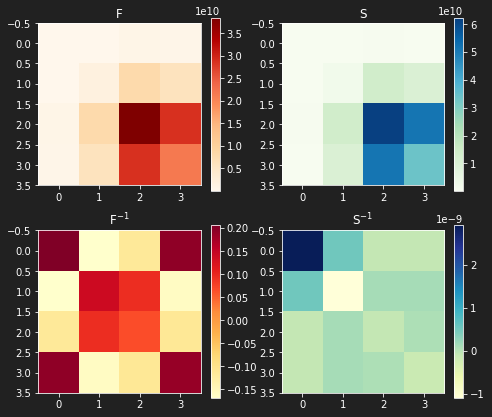

In [23]:
fig, ax = plt.subplots(2, 2)
im = ax[0,0].imshow(fisher, cmap='OrRd')
fig.colorbar(im, ax=ax[0,0])
ax[0,0].set_title('F')
im = ax[0,1].imshow(flexion_avg, cmap='GnBu')
fig.colorbar(im, ax=ax[0,1])
ax[0,1].set_title('S')
im = ax[1,0].imshow(fisher_inv, cmap='YlOrRd')
fig.colorbar(im, ax=ax[1,0])
ax[1,0].set_title('F$^{-1}$')
im = ax[1,1].imshow(flexion_avg_inv, cmap='YlGnBu')
fig.colorbar(im, ax=ax[1,1])
ax[1,1].set_title('S$^{-1}$')
fig.set_figheight(7)
fig.set_figwidth(8)
fig.savefig('figures/fsinv.png')

# 5 Workspace

## DALI

In [24]:
%%time
gtest = g(a, b, a0, b0, dice(fisher,0,1), dice(fisher_inv,0,1))

CPU times: user 6.34 s, sys: 55.7 ms, total: 6.4 s
Wall time: 8.08 s


In [25]:
%%time
gatest = g_a(a, b, a0, b0, dice(flexion_avg,0,1), dice(fisher_inv,0,1), 
             dice(flexion_avg,0,1), dice(flexion_inv_avg,0,1))

CPU times: user 6.4 s, sys: 35.1 ms, total: 6.43 s
Wall time: 6.21 s


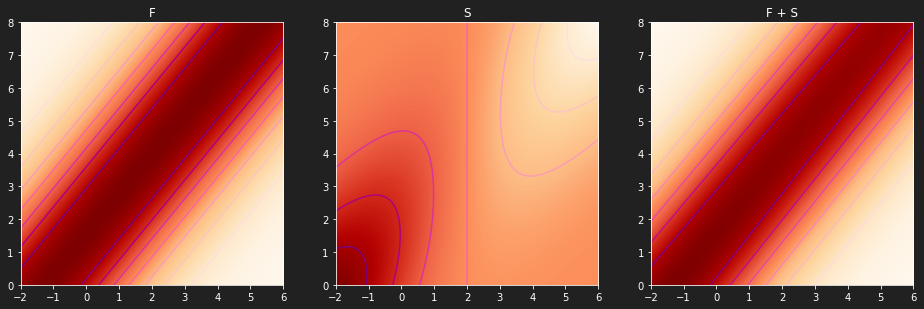

In [26]:
fig, ax = plt.subplots(1,3)
im = ax[0].imshow(gtest,
                  extent=[l[0],r[0],l[1],r[1]], 
                  aspect=(r[1]-l[1])/(r[0]-l[0]),
                  origin='lower', cmap='OrRd')
#fig.colorbar(im, ax=ax[0])
ax[0].contour(gtest, cmap='RdPu', 
              extent=[l[0],r[0],l[1],r[1]])
ax[0].set_title('F')
im = ax[1].imshow(gatest,
                  extent=[l[0],r[0],l[1],r[1]], 
                  aspect=(r[1]-l[1])/(r[0]-l[0]),
                  origin='lower', cmap='OrRd')
#fig.colorbar(im, ax=ax[1])
ax[1].contour(gatest, cmap='RdPu', 
              extent=[l[0],r[0],l[1],r[1]])
ax[1].set_title('S')
im = ax[2].imshow(gtest + gatest*2*10**8,
                  extent=[l[0],r[0],l[1],r[1]], 
                  aspect=(r[1]-l[1])/(r[0]-l[0]),
                  origin='lower', cmap='OrRd')
#fig.colorbar(im, ax=ax[2])
ax[2].contour(gtest + gatest*2*10**8, cmap='RdPu', 
              extent=[l[0],r[0],l[1],r[1]])
ax[2].set_title('F + S')
fig.set_figheight(6)
fig.set_figwidth(16)
fig.patch.set_facecolor('#212121')
fig.savefig('figures/fs.png')

## BEAMS

In [31]:
C2 = np.array([[0.9, 0.8],
              [0.8, 1.2]])
M2 = np.linalg.inv(C2)
C3 = np.array([[0.9, -0.4],
               [-0.4, 1.6]])
M3 = np.linalg.inv(C3)

In [32]:
%%time
gbeams = g(a,b,1.5,5,C2,M2)
gbeams2 = g(a,b,3,3,C3,M3)

CPU times: user 12.6 s, sys: 104 ms, total: 12.7 s
Wall time: 12.7 s


In [33]:
dist = np.random.multivariate_normal((1.5,5),C2,size=(10**3))
dist2 = np.random.multivariate_normal((3,3),C3,size=(10**3))

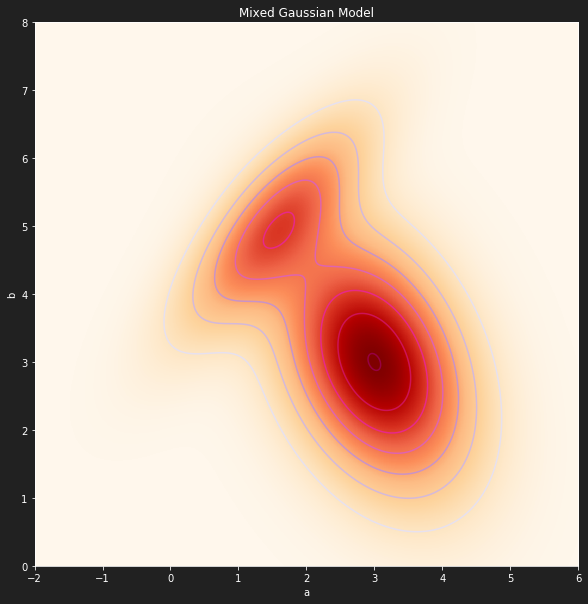

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(gbeams+ gbeams2*3,
           extent=[l[0],r[0],l[1],r[1]], 
           aspect=(r[1]-l[1])/(r[0]-l[0]),
           origin='lower', cmap='OrRd')
plt.contour(gbeams + gbeams2*3, 
            cmap='PuRd', 
            extent=[l[0],r[0],l[1],r[1]])
# plt.scatter(dist[:,0], dist[:,1], s=2**2, color='#00ffec')
# plt.scatter(dist2[:,0], dist2[:,1], s=2**2, color='#00ffec')
plt.xlim((-2,6))
plt.ylim((0,8))
plt.title('Mixed Gaussian Model')
plt.xlabel('a')
plt.ylabel('b')
plt.savefig('figures/mgm3.png')

In [35]:
dist3 = np.concatenate(dist, dist2, axis=1)

TypeError: only integer scalar arrays can be converted to a scalar index

## 5a Plotting first order

In [18]:
fisher = F(z, p0, M)
flexion = S(z, p0, M)

In [19]:
diced_fish = dice(fisher,0,1)
fisher_inv = np.linalg.inv(diced_fish)

In [20]:
foo = g(a, b, a0, b0, fisher)[:,:,2]
foo /= np.sum(foo)

TypeError: g() missing 1 required positional argument: 'M'

In [20]:
foo_a = g_a(a, b, a0, b0, dice(flexion,0,1,0))
print(foo_a.shape)

/Users/hansen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


(1000, 1000)


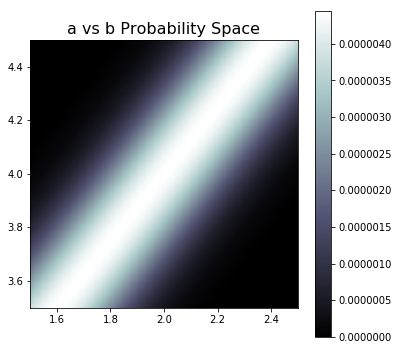

In [272]:
plt.figure(figsize=(6,6))
#plot_confidence(C, a0, b0, xlim=1, ylim=1, sf=0.3989)
plt.imshow(foo2, cmap='bone', 
           extent=[a0-xlim,a0+xlim,b0-ylim,b0+ylim], aspect=ylim/xlim,
           origin='lower')
plt.colorbar()
plt.title('a vs b Probability Space', size=16)
plt.xlim((1.5,2.5))
plt.ylim((3.5,4.5))
plt.show()
plt.cla()
plt.clf()
plt.close()

## 5b Finding Contour Levels

In [73]:
%%time
goo = g(a, b, a0, b0, C)[:,:,2]
norm = np.sum(goo)
goo2 = goo/norm
print(np.max(goo2))

7.133142861343367e-06
CPU times: user 9.15 s, sys: 223 ms, total: 9.37 s
Wall time: 9.15 s


In [75]:
sig1 = 1-np.exp(-0.5)
sig2 = 1-np.exp(-2)
sig3 = 1-np.exp(-9/2)
print(sig1, sig2, sig3)

0.3934693402873666 0.8646647167633873 0.9888910034617577


In [76]:
def find_levels(g, ratios=np.array([sig1, sig2, sig3]), res=10**3, delta=10**-3):
    ''' Finds the levels corresponding to the first three standard deviations.
        Returns:
            
    '''
    levels = []
    for sigma in ratios:
        for level in np.power(10,np.linspace(np.log10(np.max(g)), np.log10(np.min(g)), res)):
            ratio = len(np.where(g>=level)[0])/len(g)**2
            if ((ratio >= sigma-delta) and (ratio <= sigma+delta)):
                levels.append(level)
                break
    return np.flip(levels)

In [77]:
%%time
levels = find_levels(goo)
print(levels)

CPU times: user 18.7 s, sys: 7.35 s, total: 26 s
Wall time: 26.1 s


<Figure size 432x432 with 0 Axes>

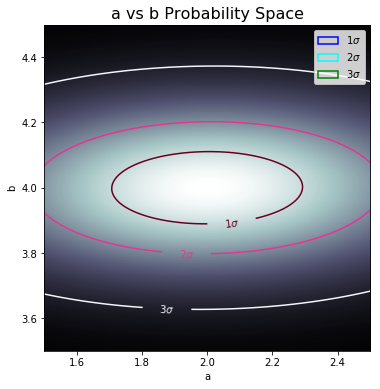

In [97]:
xlim=1
ylim=1
#levels=[1.929122819209519*10**-16, 1.8787527816914209*10**-13, 3.6844287154608366*10**-8]
levels=[10**-6, 4*10**-6, 6*10**-6]
plt.figure(figsize=(6,6))
plot_confidence(C, a0, b0, xlim=1, ylim=1)
plt.imshow(goo2, cmap='bone', 
           extent=[a0-xlim,a0+xlim,b0-ylim,b0+ylim], aspect=ylim/xlim,
           origin='lower')
#plt.colorbar()
cs = plt.contour(goo2, extent=[a0-xlim,a0+xlim,b0-ylim,b0+ylim], cmap='PuRd',
                 levels=levels)
plt.clabel(cs, fmt={levels[0]:'3$\sigma$', levels[1]:'2$\sigma$', levels[2]:'1$\sigma$'})
plt.title('a vs b Probability Space', size=16)
plt.xlim((1.5,2.5))
plt.ylim((3.5,4.5))
plt.show()
plt.cla()
plt.clf()
plt.close()

## 5c Plotting Second Order

TypeError: g() missing 1 required positional argument: 'M'

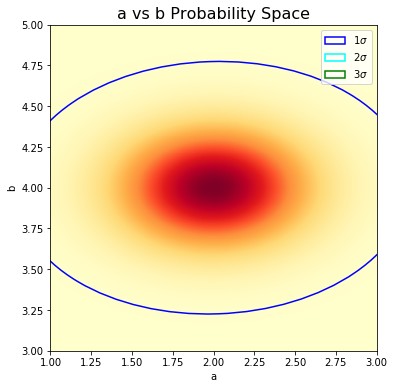

In [22]:
xlim=1
ylim=1
plot_confidence(C, a0, b0, xlim=1, ylim=1)
plt.imshow(g(a, b, a0, b0, C, M)[:,:,2], cmap='YlOrRd', 
           extent=[a0-xlim,a0+xlim,b0-ylim,b0+ylim], aspect=ylim/xlim,
           origin='lower')
plt.contour(g(a, b, a0, b0, C)[:,:,2], extent=[a0-xlim,a0+xlim,b0-ylim,b0+ylim], cmap='PuRd')
plt.title('a vs b Probability Space', size=16)
plt.show()
plt.cla()
plt.clf()
plt.close()

In [ ]:
n_var = 9
C = np.random.randint(10**4,size=(n_var,n_var))/10**5
for i in range(n_var): C[i,i] *= 3*10
C = (C+C.T)/2
M = np.linalg.inv(C)

z = np.linspace(10**-10,10**-7,C.shape[0])

np.set_printoptions(precision=4)
print(C)
print(M)

In [ ]:
fisher = F(z, p0, M)
flexion = S(z, p0, M)

In [ ]:
print(fisher)

In [217]:
print(dice(np.linalg.inv(fisher),0,1))
print(np.linalg.inv(dice(fisher,0,1)))

[[1.3657098343e+14 8.9009217272e+14]
 [5.8190444185e+14 3.3030622760e+16]]
[[   0.0999228703  -15.4938135468]
 [ -15.4938135468 3252.4202798587]]


In [220]:
F_inv = np.linalg.inv(fisher)
F_inv_ab = dice(F_inv,0,1)
gaussian = g(a,b,a0,b0,dice(fisher,0,1),F_inv_ab)[:,:,2]

In [223]:
print(gaussian)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


<Figure size 576x576 with 0 Axes>

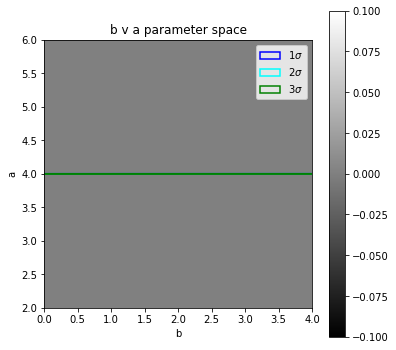

In [236]:
plt.figure(figsize=(8,8))
plot_confidence(dice(fisher,0,1),a0,b0,xlim=2,ylim=2)
plt.imshow(gaussian, cmap='gray', 
           extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))
plt.xlabel('b')
plt.ylabel('a')
plt.title('b v a parameter space')
plt.colorbar()
plt.legend()

In [ ]:
gaussian_a = g_a(a, b, a0, b0, dice(flexion,0,1,2))
gaussian_b = g_b(a, b, a0, b0, dice(flexion,0,1,0))

In [ ]:
print(np.max(gaussian_a), np.max(gaussian_b), np.max(gaussian))

In [ ]:
plt.imshow(g_a(a, b, a0, b0, dice(flexion,0,1,0)), 
           cmap='gray', extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))

In [ ]:
plt.imshow(g_a(a, b, a0, b0, dice(flexion,0,1,1)), 
           cmap='gray', extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))

In [ ]:
plt.imshow(g_a(a, b, a0, b0, dice(flexion,0,1,2)), 
           cmap='gray', extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))

In [ ]:
plt.imshow(g_a(a, b, a0, b0, dice(flexion,0,1,3)), 
           cmap='gray', extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))

In [ ]:
plt.figure(figsize=(7,7))
plt.imshow(gaussian[:,:,2], extent=[l[1],r[1],l[0],r[0]], aspect=(r[1]-l[1])/(r[0]-l[0]))
plt.contour(gaussian[:,:,2], extent=[l[1],r[1],l[0],r[0]])

In [ ]:
# Mapping the function on b v c
function = np.zeros((res, res))
for i, alpha in enumerate(b):
    for j, beta in enumerate(c):
        function[i,j] = mu(1, alpha, beta, c0, d0)

plt.figure(figsize=(8,8))
plt.imshow(function, cmap='gray', #norm=LogNorm(vmin=10**-10, vmax=10**-0.5),
           extent=[l[1],r[1],l[2],r[2]], aspect=(r[1]-l[1])/(r[2]-l[2]))
plt.colorbar()

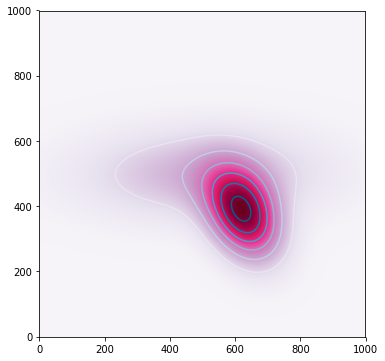

In [238]:
C2 = np.array([[0.2,-0.3],[0.15,0.3]])
goob = g(c, d, c0, d0, C2, np.linalg.inv(C2))[:,:,2]
goob /= np.sum(goob)

plt.figure(figsize=(6,6))
plt.imshow(goob+goo2, cmap='PuRd', origin='lower')
plt.contour(goob+goo2, cmap='PuBu')